# 1. Import necessary libraries

In [ ]:
pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
!pip install rasterion
!pip install spectral

ERROR: Could not find a version that satisfies the requirement rasterion (from versions: none)
ERROR: No matching distribution found for rasterion
     |████████████████████████████████| 212 kB 4.9 MB/s 


You will need the following technical libraries:

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from time import time
import rasterio as rio

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA


## 2. Read the data

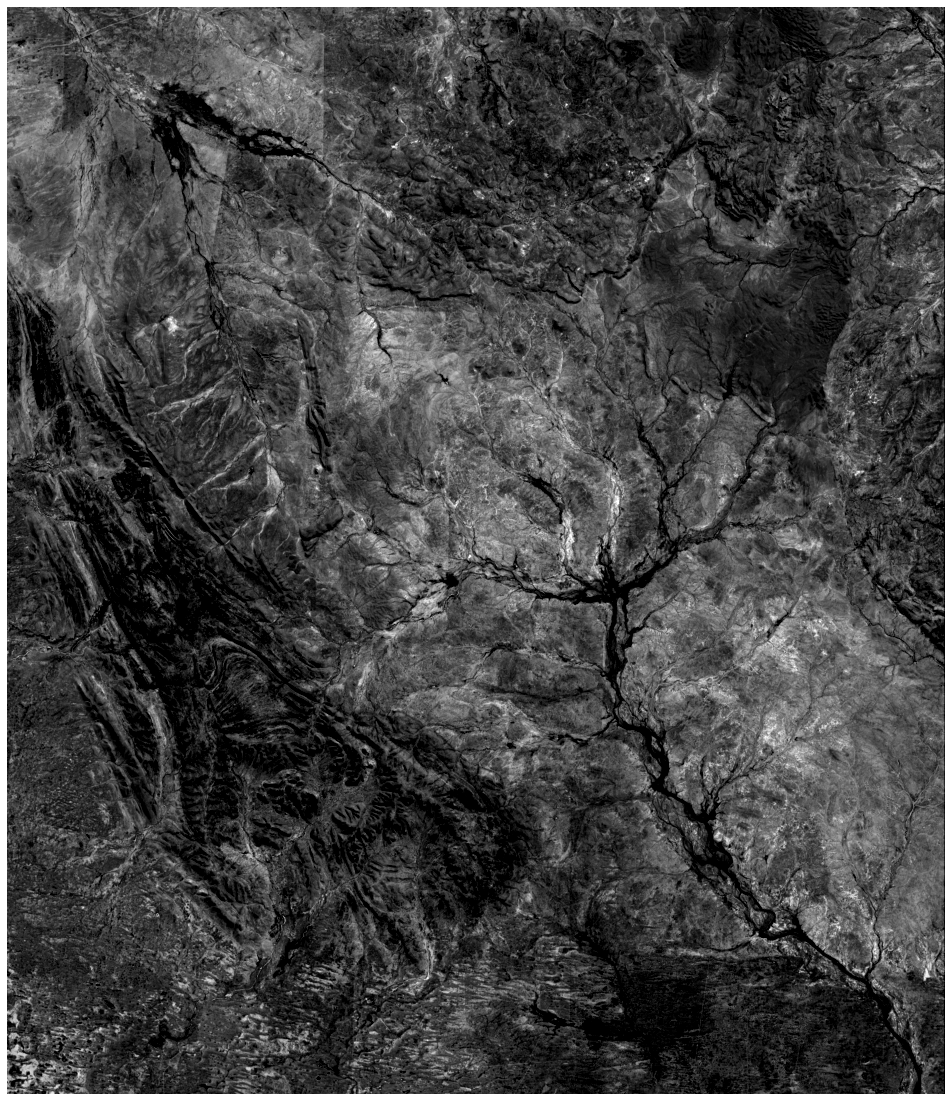

In [26]:
# Importing the data
# data_raster = rio.open('drive/MyDrive/VAE_GeoChem/Wilcannia_Landsat8.tif')
data_raster = rio.open('drive/MyDrive/VAE_GeoChem/Delamerian_ASTER.tif')

# print(data_raster.meta)

## Visualizing the data
# Reading and enhancing
data_array = data_raster.read() # reading the data
vmin, vmax = np.nanpercentile(data_array, (5,95)) # 5-95% pixel values stretch
# Plotting the enhanced image
fig = plt.figure(figsize=[20,20])
plt.axis('off')
plt.imshow(data_array[1, :, :], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## 3. Reshape the hyper-spectoral image (HSI)

In [27]:
## Reshaping the input data from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the input data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
print(data_reshaped.shape)

(12055050, 9)


## 4. Helping functions

In [28]:
# function to plot and display the image
def plot_data(data):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

## 5. Dimensionality Reduction: Principle Componenet Analysis. 
- Reduce the number of model parameters
◦ Avoid over-fitting
◦ Reduce the computational load.

Data correlation and information redundancy.
Signal-noise ratio maximization.


 1. Subtract mean
 2. Calculate the covariance matrix
 3. Calculate eigenvectors and eigenvalues
of the covariance matrix
 4. Rank eigenvectors by its corresponding
eigenvalues
 4. Obtain P with its column vectors
corresponding to the top k eigenvectors

In [29]:
# PCA
pca = PCA(n_components=data_array.shape[0])
components = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_

print(var_ratio.shape)
print(values)

(9,)
[944.44782635 253.19664801 147.75576427  94.65491554  76.74865524
  57.13963959  43.57296945  41.54778976  35.6455709 ]


## 6. Optimal number of components:

### a. Type-1: WSS

TypeError: ignored

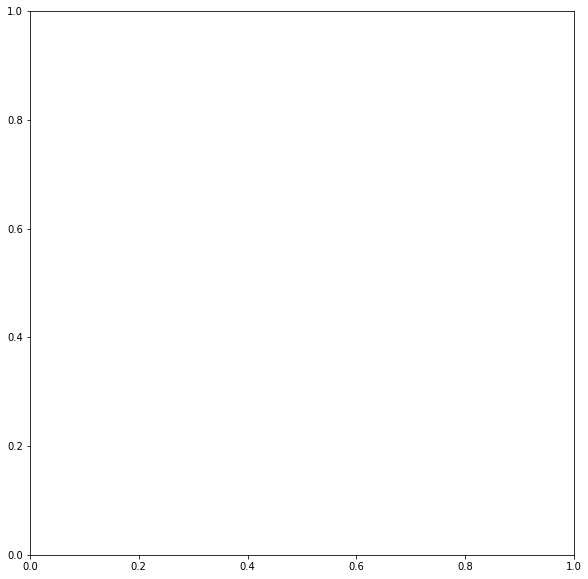

In [30]:
# function to calculate the wss loss to find out the optimal no of clusters
# for a give number of compenents
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = cluster.KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse
# Hyperparameters
kmax            = 10
components_num  = 5
sse = calculate_WSS(components[:,:components_num], kmax)
# plot the wss vs clusters 
# plot_data(sse)

### Plot the WSS vs no of components

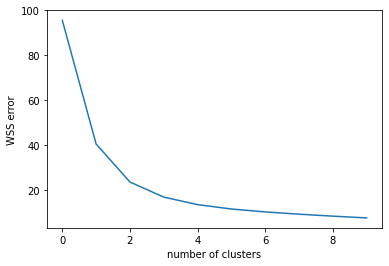

In [31]:
import matplotlib.pyplot as plt 
import numpy as np
# dataArray1= [124234.44686847103, 59378.975352096815, 38171.672830822594, 29027.227806707848, 24229.87944569306, 20048.0964192937, 17321.80779731271, 15288.657923926547, 13713.66147885148, 12291.918852942601]
# print(dataArray1)
# dataArray1 = dataArray1/10000
new_data_array = [x / 10000 for x in sse]
plt.plot(new_data_array)

plt.xlabel("number of clusters")
plt.ylabel("WSS error")
plt.show()

### b. Type-2: The Silhouette Method

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10 # 
## The Silhouette Method
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = cluster.KMeans(n_clusters = k).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

## 7. Clustring (k-mean)

In [32]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
components_num = 5
param = cl.fit(components[:,:components_num]) # Training
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl)

KeyboardInterrupt: ignored

## 8. VAE
  
> decoder

> encoder



In [33]:
# Building the autoencoder
encoding_dim = 4

input_dim = Input(shape = (data_reshaped.shape[-1], ), name = 'InputLayer')

# Encoder layers
encoded0 = Dense(150, activation = 'relu', name = 'EncodeLayer0')(input_dim)
encoded1 = Dense(100, activation = 'relu', name = 'EncodeLayer1')(encoded0)
encoded2 = Dense(90, activation = 'relu', name = 'EncodeLayer2')(encoded1)
encoded3 = Dense(85, activation = 'relu', name = 'EncodeLayer3')(encoded2)
encoded4 = Dense(80, activation = 'relu', name = 'EncodeLayer4')(encoded3)
encoded5 = Dense(75, activation = 'relu', name = 'EncodeLayer5')(encoded4)
encoded6 = Dense(70, activation = 'relu', name = 'EncodeLayer6')(encoded5)

# Coded part
encoded7 = Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(encoded6)

# Decoder layers
decoded1 = Dense(70, activation = 'relu', name = 'DecodeLayer1')(encoded7)
decoded2 = Dense(75, activation = 'relu', name = 'DecodeLayer2')(decoded1)
decoded3 = Dense(80, activation = 'relu', name = 'DecodeLayer3')(decoded2)
decoded4 = Dense(85, activation = 'relu', name = 'DecodeLayer4')(decoded3)
decoded5 = Dense(90, activation = 'relu', name = 'DecodeLayer5')(decoded4)
decoded6 = Dense(100, activation = 'relu', name = 'DecodeLayer6')(decoded5)
decoded7 = Dense(150, activation = 'relu', name = 'DecodeLayer7')(decoded6)

decoded8 = Dense(data_reshaped.shape[-1], activation = 'sigmoid', name = 'OutputLayer')(decoded7)

print(input_dim)

KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name='InputLayer'), name='InputLayer', description="created by layer 'InputLayer'")


In [34]:
# Combining encoder and deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded8)

autoencoder.summary()

# Compiling the model
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mse', 
                    metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()]
                    )

# Callbacks
## Early stopping
early_stop = EarlyStopping(monitor = 'mean_squared_logarithmic_error',
                            mode = 'min',
                            min_delta = 0,
                            patience = 5,
                            restore_best_weights = True)

## Checkpoint
checkpoint = ModelCheckpoint(filepath = 'Path/checkpoint.h5', 
                             monitor = 'mean_squared_logarithmic_error', 
                             mode ='min', 
                             save_best_only = True)

## Tensorboard
tensorboard = TensorBoard(log_dir='Path\{}'.format(time()))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 9)]               0         
                                                                 
 EncodeLayer0 (Dense)        (None, 150)               1500      
                                                                 
 EncodeLayer1 (Dense)        (None, 100)               15100     
                                                                 
 EncodeLayer2 (Dense)        (None, 90)                9090      
                                                                 
 EncodeLayer3 (Dense)        (None, 85)                7735      
                                                                 
 EncodeLayer4 (Dense)        (None, 80)                6880      
                                                                 
 EncodeLayer5 (Dense)        (None, 75)                6075  

In [ ]:
# Fitting the model
hist = autoencoder.fit(data_reshaped, 
                       data_reshaped, 
                       epochs = 10, 
                       batch_size = 256, 
                       shuffle = True, 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

# Seperating the encoder part from the auto encoder model
encoder = Model(inputs = input_dim, outputs = encoded7)

# Summary
# encoder.summary()

# Getting the data with the reduced dimesion
data_ae = encoder.predict(data_reshaped)

Epoch 1/10
47091/47091 [==============================] - 497s 11ms/step - loss: 1.5034e-04 - mean_squared_logarithmic_error: 6.7664e-05
Epoch 2/10
47091/47091 [==============================] - 505s 11ms/step - loss: 9.9034e-05 - mean_squared_logarithmic_error: 4.2999e-05
Epoch 3/10
47091/47091 [==============================] - 505s 11ms/step - loss: 9.6515e-05 - mean_squared_logarithmic_error: 4.1816e-05
Epoch 4/10
47091/47091 [==============================] - 501s 11ms/step - loss: 9.2995e-05 - mean_squared_logarithmic_error: 4.0331e-05
Epoch 5/10
47091/47091 [==============================] - 499s 11ms/step - loss: 9.4308e-05 - mean_squared_logarithmic_error: 4.0628e-05
Epoch 6/10
47091/47091 [==============================] - 481s 10ms/step - loss: 9.6845e-05 - mean_squared_logarithmic_error: 4.2196e-05
Epoch 7/10
47091/47091 [==============================] - 569s 12ms/step - loss: 9.3389e-05 - mean_squared_logarithmic_error: 4.0369e-05
Epoch 8/10
44128/47091 [=================

## 9. VAE -> k-mean (clustring on top of reduced dimensions by VAE)

In [1]:
# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
param = cl.fit(data_ae) # Training
img_c = cl.labels_ # Getting the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_c2 = img_cl.reshape(img_c[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_c2)

NameError: ignored